In [511]:
!pip install numpy_financial


In [512]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from scipy.optimize import newton,fsolve,root,brentq
from datetime import datetime, timedelta
import numpy_financial as npf
import math


Load The Dataset

In [513]:
df = pd.read_csv("/content/mat1856.csv")
print(df)

    coupon          ISIN  issue date maturity date    Jan 8    Jan 9   Jan 10  \
0     2.25  CA135087J546   10/5/2018      3/1/2024   99.630   99.640   99.650   
1     1.50  CA135087J967    4/5/2019      9/1/2024   97.960   97.980   97.985   
2     1.25  CA135087K528  10/11/2019      3/1/2025   96.460   96.482   96.552   
3     0.50  CA135087K940    4/3/2020      9/1/2025   94.340   94.370   94.380   
4     0.25  CA135087L518   10/9/2020      3/1/2026   92.862   92.860   92.844   
5     1.00  CA135087L930   4/16/2021      9/1/2026   93.460   93.440   93.550   
6     1.25  CA135087M847  10/15/2021      3/1/2027   93.282   93.301   93.245   
7     2.75  CA135087N837   5/13/2022      9/1/2027   97.580   97.591   97.603   
8     3.50  CA135087P576  10/21/2022      3/1/2028  100.500  100.480  100.439   
9     3.25  CA135087Q491   4/21/2023      9/1/2028   99.740   99.720   99.720   
10    4.00  CA135087Q988  10/13/2023      3/1/2029  103.406  103.380  103.279   

     Jan 11   Jan 12   Jan 

Filtering And Calculation of Yield To Maturity

In [514]:
df['issue date'] = pd.to_datetime(df['issue date'])
df['maturity date'] = pd.to_datetime(df['maturity date'])

def calculate_ytm(price, coupon, maturity_date, current_date):
    # Convert the column name to datetime and set the year to 2024
    current_date_str = f"{current_date} 2024"
    current_date_dt = datetime.strptime(current_date_str, "%b %d %Y")
    years_to_maturity = (maturity_date - current_date_dt).days / 365.25

    freq=2
    nper = years_to_maturity * freq
    pmt =  coupon / freq
    pv = -price
    fv = 100
    ytm = npf.rate(nper=nper, pmt=pmt, pv=pv, fv=fv) * freq

    return ytm # Convert back to annual yield

# Apply the function to calculate YTM for each bond and date
for date_column in df.columns[4:]:
    df[date_column + '_YTM'] = df.apply(lambda row: calculate_ytm(row[date_column], row['coupon'], row['maturity date'], date_column), axis=1)

# Display the updated DataFrame
print(df)

    coupon          ISIN issue date maturity date    Jan 8    Jan 9   Jan 10  \
0     2.25  CA135087J546 2018-10-05    2024-03-01   99.630   99.640   99.650   
1     1.50  CA135087J967 2019-04-05    2024-09-01   97.960   97.980   97.985   
2     1.25  CA135087K528 2019-10-11    2025-03-01   96.460   96.482   96.552   
3     0.50  CA135087K940 2020-04-03    2025-09-01   94.340   94.370   94.380   
4     0.25  CA135087L518 2020-10-09    2026-03-01   92.862   92.860   92.844   
5     1.00  CA135087L930 2021-04-16    2026-09-01   93.460   93.440   93.550   
6     1.25  CA135087M847 2021-10-15    2027-03-01   93.282   93.301   93.245   
7     2.75  CA135087N837 2022-05-13    2027-09-01   97.580   97.591   97.603   
8     3.50  CA135087P576 2022-10-21    2028-03-01  100.500  100.480  100.439   
9     3.25  CA135087Q491 2023-04-21    2028-09-01   99.740   99.720   99.720   
10    4.00  CA135087Q988 2023-10-13    2029-03-01  103.406  103.380  103.279   

     Jan 11   Jan 12   Jan 15  ...  Jan

Creation of a separate DataFrame for plotting Yield Curve

In [515]:
ytm_columns = [col for col in df.columns if col.endswith('_YTM')]

# Create a new DataFrame with only YTM columns
df_ytm_only = df[ytm_columns].copy()

# Display the new DataFrame
print(df_ytm_only)

    Jan 8_YTM  Jan 9_YTM  Jan 10_YTM  Jan 11_YTM  Jan 12_YTM  Jan 15_YTM  \
0    0.048395   0.048177    0.047949    0.047639    0.047468    0.047723   
1    0.047294   0.047108    0.047164    0.047350    0.046851    0.046720   
2    0.044572   0.044444    0.043867    0.043718    0.042997    0.042711   
3    0.040860   0.040722    0.040716    0.040445    0.040108    0.040285   
4    0.037463   0.037518    0.037645    0.037629    0.036814    0.037025   
5    0.036125   0.036235    0.035804    0.035914    0.035648    0.035853   
6    0.035268   0.035221    0.035438    0.035667    0.034660    0.034658   
7    0.034621   0.034593    0.034562    0.034816    0.034163    0.034081   
8    0.033697   0.033749    0.033855    0.034143    0.033338    0.033241   
9    0.033108   0.033155    0.033156    0.033555    0.032781    0.032711   
10   0.032752   0.032803    0.033010    0.033315    0.032454    0.032422   

    Jan 16_YTM  Jan 17_YTM  Jan 18_YTM  Jan 19_YTM  
0     0.048868    0.049215    0.04

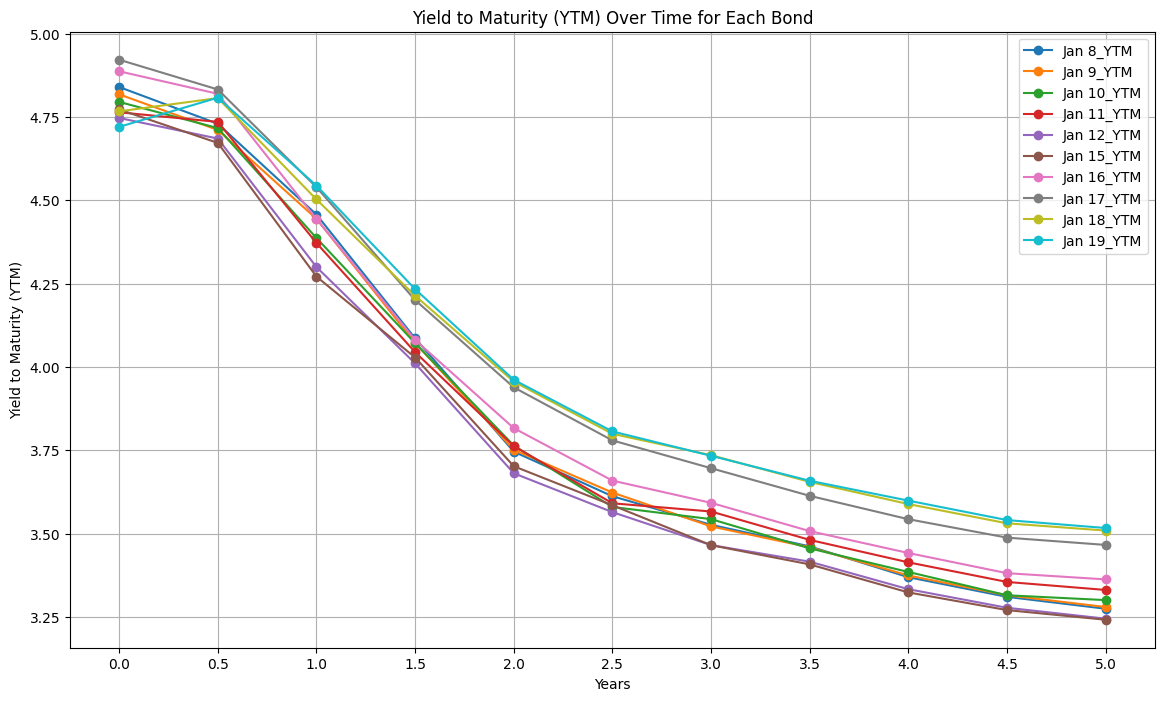

In [516]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 8))  # Set the figure size

# Iterate through each bond column to plot its YTM
for bond in df_ytm_only.columns:
    plt.plot(df_ytm_only.index * 0.5, df_ytm_only[bond]*100, marker='o', label=bond)  # Assuming each row represents 0.5 year

plt.title('Yield to Maturity (YTM) Over Time for Each Bond')
plt.xlabel('Years')
plt.ylabel('Yield to Maturity (YTM)')

# Setting x-axis to range from 0 to 5 years, with each tick representing 0.5 year
plt.xticks(np.arange(0, 5.5, 0.5))

plt.legend(loc='best')  # Show legend to identify each line
plt.grid(True)
plt.show()

Calculating Spot Rates for our Bonds

In [517]:


for date_column in df.columns[4:14]:

        # Iterate through each bond (excluding the first one)
        for i in range(0, len(df)):
            #print(f"Processing column: {date_column}")
            current_date_str = f"{date_column} 2024"
            current_date_dt = datetime.strptime(current_date_str, "%b %d %Y")

            time_to_maturity = (df.at[i, 'maturity date'] - current_date_dt).days / 365.25
            #print(time_to_maturity)
            if time_to_maturity < 0.5:
                # If time to maturity is less than 0.5, set spot rate as YTM
                df.at[i, f'{date_column}_Spot'] = df.at[i, f'{date_column}_YTM']
            else:
                pi = (df.at[i, 'coupon'])/2   # divide by 2 because this coupon is paid twice a year
                pn = 100 + pi
                tn = time_to_maturity
                P = df.at[i, date_column]

                sum_term = 0
                for j in range(0,i-1):
                    tj = tn - 0.5 * (i - j)
                    r_tj = df.at[j, f'{date_column}_Spot']
                    sum_term += pi * math.exp(-r_tj * tj)

                df.at[i, f'{date_column}_Spot'] = (np.log(pn) - np.log(P - sum_term)) / tn



Creation of Spot Rate Dataset for plotting Spot Curve

In [518]:
spot_columns = [col for col in df.columns if col.endswith('_Spot')]

# Create a new DataFrame with only YTM columns
df_spot_only = df[spot_columns].copy()

# Display the new DataFrame
print(df_spot_only)

    Jan 8_Spot  Jan 9_Spot  Jan 10_Spot  Jan 11_Spot  Jan 12_Spot  \
0     0.048395    0.048177     0.047949     0.047639     0.047468   
1     0.043280    0.043147     0.043251     0.043484     0.043047   
2     0.042578    0.042480     0.041942     0.041824     0.041145   
3     0.040034    0.039907     0.039909     0.039651     0.039328   
4     0.036964    0.037021     0.037150     0.037137     0.036340   
5     0.035300    0.035421     0.035005     0.035126     0.034877   
6     0.034461    0.034426     0.034655     0.034897     0.033910   
7     0.033373    0.033367     0.033363     0.033646     0.033016   
8     0.032368    0.032448     0.032587     0.032912     0.032128   
9     0.031944    0.032015     0.032040     0.032475     0.031719   
10    0.031561    0.031639     0.031887     0.032228     0.031378   

    Jan 15_Spot  Jan 16_Spot  Jan 17_Spot  Jan 18_Spot  Jan 19_Spot  
0      0.047723     0.048868     0.049215     0.047667     0.047202  
1      0.043074     0.044564   

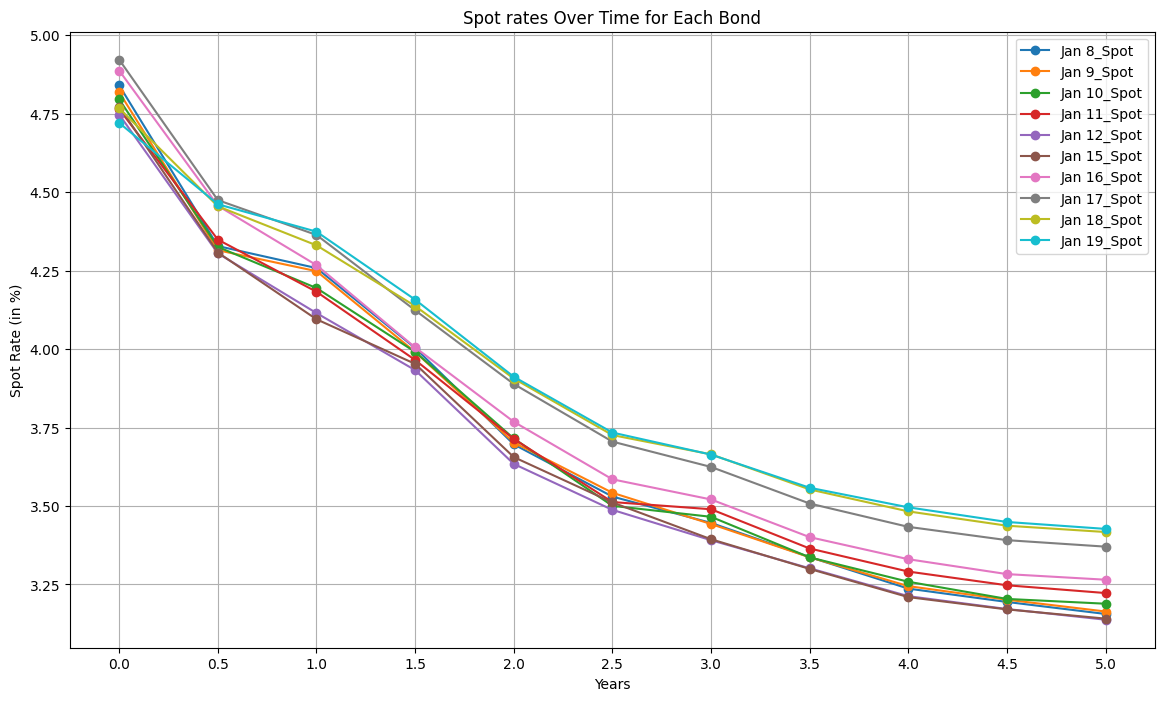

In [519]:
plt.figure(figsize=(14, 8))  # Set the figure size

# Iterate through each bond column to plot its YTM
for bond in df_spot_only.columns:
    plt.plot(df_spot_only.index * 0.5, df_spot_only[bond]*100, marker='o', label=bond)  # Assuming each row represents 0.5 year

plt.title('Spot rates Over Time for Each Bond')
plt.xlabel('Years')
plt.ylabel('Spot Rate (in %)')

# Setting x-axis to range from 0 to 5 years, with each tick representing 0.5 year
plt.xticks(np.arange(0, 5.5, 0.5))

plt.legend(loc='best')  # Show legend to identify each line
plt.grid(True)
plt.show()

Calculation of Semi-Annual Period Forward Rates

In [520]:
date_column_prefix = 'Jan'
spot_column_suffix = '_Spot'

def calculate_forward_rate(r_0t, t, r_01):
    return (((1+r_0t)**(1+t))/(1+r_01))**(1/t) -1


# Iterate through each date column
for date_column in df.columns[4:14]:
    r_01 = df.at[0, f'{date_column}_Spot']
    #print(r_01)
    # Iterate through each bond
    for j in range(1,8):
        #print(r_0t)
        # Calculate forward rate
        forward_rate = calculate_forward_rate(r_0t = df.at[j, f'{date_column}_Spot'] ,t = j/2, r_01 = r_01)
        #print(forward_rate)
        df.at[j-1, f'{date_column}_Forward'] = forward_rate

# Example usage:
# Assuming df is your DataFrame
print(df)

    coupon          ISIN issue date maturity date    Jan 8    Jan 9   Jan 10  \
0     2.25  CA135087J546 2018-10-05    2024-03-01   99.630   99.640   99.650   
1     1.50  CA135087J967 2019-04-05    2024-09-01   97.960   97.980   97.985   
2     1.25  CA135087K528 2019-10-11    2025-03-01   96.460   96.482   96.552   
3     0.50  CA135087K940 2020-04-03    2025-09-01   94.340   94.370   94.380   
4     0.25  CA135087L518 2020-10-09    2026-03-01   92.862   92.860   92.844   
5     1.00  CA135087L930 2021-04-16    2026-09-01   93.460   93.440   93.550   
6     1.25  CA135087M847 2021-10-15    2027-03-01   93.282   93.301   93.245   
7     2.75  CA135087N837 2022-05-13    2027-09-01   97.580   97.591   97.603   
8     3.50  CA135087P576 2022-10-21    2028-03-01  100.500  100.480  100.439   
9     3.25  CA135087Q491 2023-04-21    2028-09-01   99.740   99.720   99.720   
10    4.00  CA135087Q988 2023-10-13    2029-03-01  103.406  103.380  103.279   

     Jan 11   Jan 12   Jan 15  ...  Jan

Creation of Forward Rate Dataset for Plotting

In [521]:
forward_columns = [col for col in df.columns if col.endswith('_Forward')]

# Create a new DataFrame with only YTM columns
df_forward_only = df[forward_columns].copy()

# Display the new DataFrame
print(df_forward_only)

    Jan 8_Forward  Jan 9_Forward  Jan 10_Forward  Jan 11_Forward  \
0        0.033123       0.033160        0.033919        0.035225   
1        0.036793       0.036815        0.035970        0.036042   
2        0.034496       0.034430        0.034583        0.034360   
3        0.031295       0.031488        0.031793        0.031926   
4        0.030108       0.030362        0.029872        0.030163   
5        0.029857       0.029882        0.030262        0.030684   
6        0.029120       0.029174        0.029233        0.029683   
7             NaN            NaN             NaN             NaN   
8             NaN            NaN             NaN             NaN   
9             NaN            NaN             NaN             NaN   
10            NaN            NaN             NaN             NaN   

    Jan 12_Forward  Jan 15_Forward  Jan 16_Forward  Jan 17_Forward  \
0         0.034261        0.033837        0.036009        0.035856   
1         0.034860        0.034216        0

<Figure size 1400x800 with 0 Axes>

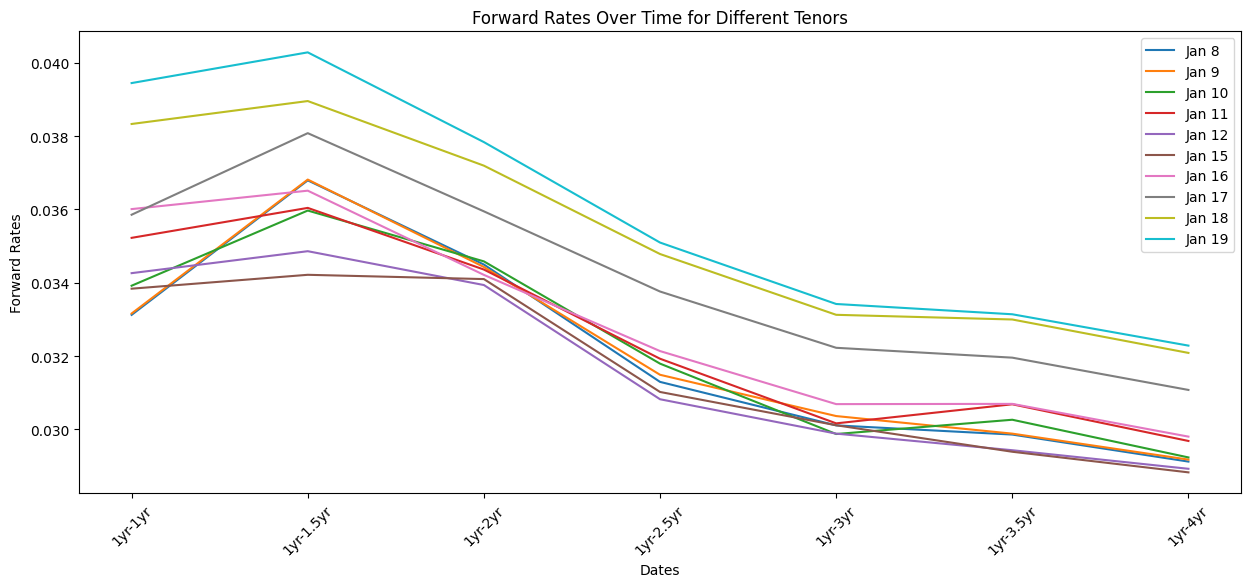

In [522]:
plt.figure(figsize=(14, 8))  # Set the figure size

# Iterate through each bond column to plot its YTM
dates = ["Jan 8", "Jan 9", "Jan 10", "Jan 11", "Jan 12","Jan 15", "Jan 16", "Jan 17","Jan 18","Jan 19"]
#forward_curve_X = ["1yr-1yr", "1yr-2yr", "1yr-3yr", "1yr-4yr"]
#forward_curve_X = ["1yr-1yr", "1yr-1.5yr", "1yr-2yr", "1yr-2.5yr", "1yr-3yr", "1yr-3.5yr", "1yr-4yr", "1yr-4.5yr", "1yr-5yr", "1yr-5.5yr", "1yr-6yr"]

df_forward_subset = df_forward_only[[f"{date}_Forward" for date in dates]]

# Plot the forward rates
forward_curve_X = ["1yr-1yr", "1yr-1.5yr", "1yr-2yr", "1yr-2.5yr","1yr-3yr","1yr-3.5yr","1yr-4yr"]

plt.figure(figsize=(15, 6))

for date in dates:
    forward_rates = df_forward_only[f'{date}_Forward'][:7]  # Take only the first 4 elements
    plt.plot(forward_curve_X, forward_rates, label=date)

plt.title('Forward Rates Over Time for Different Tenors')
plt.xlabel('Dates')
plt.ylabel('Forward Rates')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Calculation of Covariance Matrices

In [523]:
selected_rows = df_ytm_only.iloc[::2].head(5)

# Creating a 5x10 matrix
matrix_5x10 = selected_rows.values

# Displaying the result
print(matrix_5x10)

[[0.04839549 0.0481767  0.04794947 0.04763856 0.04746764 0.04772299
  0.04886764 0.04921514 0.04766709 0.04720237]
 [0.04457162 0.04444356 0.0438669  0.04371809 0.04299735 0.04271105
  0.04443986 0.04539202 0.04502497 0.04543919]
 [0.03746265 0.03751789 0.03764527 0.03762881 0.03681416 0.03702506
  0.03816789 0.03938975 0.03956298 0.03961653]
 [0.03526839 0.03522082 0.03543845 0.03566723 0.03466034 0.03465753
  0.03592763 0.03696571 0.03735597 0.03733806]
 [0.03369744 0.03374863 0.03385454 0.03414308 0.03333777 0.03324095
  0.0344231  0.03543655 0.03589032 0.03599389]]


In [524]:
yield_X = np.log(matrix_5x10.T[1:]/matrix_5x10.T[:-1]).T
yield_cov = np.cov(yield_X)
print(yield_X)
print(yield_cov)

[[-4.53119035e-03 -4.72775755e-03 -6.50533315e-03 -3.59423681e-03
   5.36501885e-03  2.37021122e-02  7.08599532e-03 -3.19600470e-02
  -9.79719394e-03]
 [-2.87735391e-03 -1.30598757e-02 -3.39821420e-03 -1.66234035e-02
  -6.68080628e-03  3.96791882e-02  2.11995020e-02 -8.11920764e-03
   9.15784492e-03]
 [ 1.47356730e-03  3.38948522e-03 -4.37423357e-04 -2.18874727e-02
   5.71240548e-03  3.03996173e-02  3.15110588e-02  4.38830190e-03
   1.35248423e-03]
 [-1.34974049e-03  6.16008190e-03  6.43501370e-03 -2.86364566e-02
  -8.11129343e-05  3.59917896e-02  2.84840136e-02  1.05020320e-02
  -4.79578991e-04]
 [ 1.51791599e-03  3.13333073e-03  8.48703463e-03 -2.38690221e-02
  -2.90854200e-03  3.49454228e-02  2.90157786e-02  1.27239008e-02
   2.88160682e-03]]
[[2.23387346e-04 1.79341544e-04 1.29354075e-04 1.14970338e-04
  9.68924802e-05]
 [1.79341544e-04 3.30463817e-04 2.51241016e-04 2.74788449e-04
  2.65709970e-04]
 [1.29354075e-04 2.51241016e-04 2.64561012e-04 2.90664959e-04
  2.67730516e-04]
 [1.

In [525]:
matrix7x10 = df_forward_only.values
matrix7x10 = matrix7x10[:-4, :]

# Displaying the result
print(matrix7x10)

[[0.03312307 0.0331605  0.03391864 0.03522462 0.03426138 0.0338374
  0.03600901 0.03585551 0.03833138 0.03944772]
 [0.03679308 0.03681453 0.03596952 0.03604206 0.03486032 0.03421631
  0.03651178 0.03808101 0.03895716 0.04028544]
 [0.03449639 0.03442972 0.03458258 0.03435978 0.03393701 0.0340996
  0.03421425 0.0359476  0.03719422 0.03783698]
 [0.03129471 0.03148848 0.03179262 0.03192648 0.03082089 0.03101971
  0.03213541 0.03376015 0.03478348 0.03509624]
 [0.03010768 0.03036223 0.02987217 0.03016279 0.02988288 0.03011132
  0.03068808 0.03222475 0.03312472 0.03342007]
 [0.0298574  0.02988249 0.03026173 0.03068374 0.02943017 0.02938819
  0.03069455 0.03195567 0.03299699 0.03313942]
 [0.02912004 0.02917397 0.02923327 0.02968254 0.02892341 0.02882597
  0.02980109 0.03107493 0.03208521 0.03228414]]


In [526]:
forward_X = np.log(abs(matrix7x10.T[1:]/matrix7x10.T[:-1])).T
forward_cov = np.cov(forward_X)
print(forward_X)
print(forward_cov)


[[ 0.00112932  0.02260537  0.03778048 -0.0277265  -0.01245215  0.06220256
  -0.0042719   0.06677168  0.02870729]
 [ 0.00058306 -0.02322079  0.00201461 -0.03333741 -0.01864677  0.0649326
   0.04208084  0.02274673  0.03352768]
 [-0.00193479  0.0044302  -0.0064635  -0.01238047  0.00477947  0.0033565
   0.0494202   0.03409088  0.01713363]
 [ 0.0061725   0.00961247  0.00420155 -0.03524282  0.00643005  0.03533558
   0.04932263  0.02986131  0.00895162]
 [ 0.00841893 -0.01627205  0.00968171 -0.00932346  0.00761559  0.01897329
   0.04886027  0.02754521  0.00887664]
 [ 0.00084013  0.01261117  0.01384884 -0.04171248 -0.00142749  0.0434921
   0.04026481  0.03206669  0.0043071 ]
 [ 0.00185033  0.00203056  0.01525156 -0.02590768 -0.00337477  0.03326844
   0.04185634  0.03199362  0.00618092]]
[[0.00108006 0.00066103 0.00013858 0.00041153 0.00015126 0.00059459
  0.00044826]
 [0.00066103 0.0010897  0.00036535 0.00062976 0.00046646 0.00068678
  0.00059107]
 [0.00013858 0.00036535 0.00040017 0.00037758 0

Calculation of Eigenvalues and Eigenvectors of Covariance Matrices

In [527]:
yield_eigenvalues,yield_eigenvectors = np.linalg.eig(yield_cov)
print(yield_eigenvalues)
print(yield_eigenvectors)

[1.21559132e-03 1.91294597e-04 4.66858234e-05 1.01454621e-05
 9.29501983e-07]
[[-0.25322787 -0.84767945 -0.40102715  0.21372069  0.10399949]
 [-0.48409487 -0.28145806  0.80585033 -0.09691341 -0.16627255]
 [-0.45462484  0.09165527 -0.32289402 -0.82093003  0.08202993]
 [-0.51396718  0.30490278 -0.29193243  0.36860326 -0.64944524]
 [-0.48029344  0.31757602  0.01724482  0.36760955  0.7300887 ]]


In [528]:
forward_eigenvalues,forward_eigenvectors = np.linalg.eig(forward_cov)
print(forward_eigenvalues)
print(forward_eigenvectors)

[3.46851349e-03 7.38221211e-04 2.66587816e-04 1.16890666e-04
 5.73170688e-05 7.03467973e-06 2.06944460e-07]
[[-0.40914961 -0.80312631 -0.17806741  0.34934409  0.07912953 -0.16206974
   0.03615732]
 [-0.51124318  0.0415156   0.81757469  0.00354922 -0.25185295  0.06494913
  -0.02859365]
 [-0.23544676  0.3975789  -0.32692455  0.65845841 -0.45488261  0.15253538
  -0.1259503 ]
 [-0.38181347  0.21639229 -0.26187019 -0.3425624  -0.2465112  -0.57152268
   0.48379945]
 [-0.25395192  0.37252953  0.07072713  0.27739146  0.73734181 -0.36720815
  -0.19043911]
 [-0.42499277  0.00462572 -0.30850174 -0.49283749 -0.02630313  0.16347281
  -0.67370797]
 [-0.35341176  0.0978281  -0.15566732 -0.08482228  0.34388639  0.67678993
   0.50774028]]


In [530]:
print(forward_cov)

[[0.00108006 0.00066103 0.00013858 0.00041153 0.00015126 0.00059459
  0.00044826]
 [0.00066103 0.0010897  0.00036535 0.00062976 0.00046646 0.00068678
  0.00059107]
 [0.00013858 0.00036535 0.00040017 0.00037758 0.0003123  0.00033826
  0.00031611]
 [0.00041153 0.00062976 0.00037758 0.00057804 0.00037082 0.00060449
  0.00049039]
 [0.00015126 0.00046646 0.0003123  0.00037082 0.00036858 0.00035232
  0.00034528]
 [0.00059459 0.00068678 0.00033826 0.00060449 0.00035232 0.00068058
  0.00053917]
 [0.00044826 0.00059107 0.00031611 0.00049039 0.00034528 0.00053917
  0.00045764]]
